In [3]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset

Mounted at /content/drive


Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Dataset/COMP5329S1A2Dataset/data/550.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5500.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5501.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5502.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5503.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5504.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5505.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5506.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5507.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5508.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5509.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/551.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5510.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5511.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5512.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5513.jpg  
  inflating: Dataset/COMP5329

We are using GPU.
Example of a single batch:
Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch size: torch.Size([64, 19])
Label: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


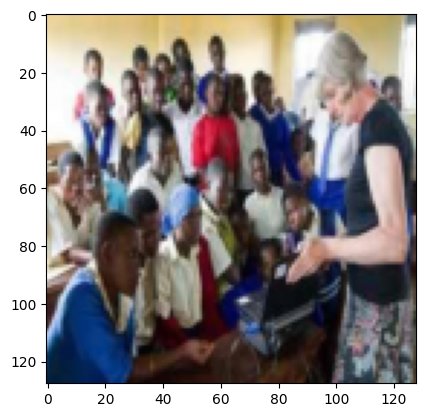

Model initialized.


 20%|██        | 1/5 [00:00<00:01,  3.58it/s]


Train Epoch: 0 [0/100 (0%)]	Loss: 0.697921


 40%|████      | 2/5 [00:00<00:00,  3.89it/s]


Train Epoch: 1 [0/100 (0%)]	Loss: 0.656703


 80%|████████  | 4/5 [00:00<00:00,  4.47it/s]


Train Epoch: 2 [0/100 (0%)]	Loss: 0.600578

Train Epoch: 3 [0/100 (0%)]	Loss: 0.516664


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]



Train Epoch: 4 [0/100 (0%)]	Loss: 0.434911


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


Test set results: Average loss: 0.2244, F1 Score: 0.51

Model works.


In [6]:
import re
import pandas as pd
from io import StringIO
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

from Dataload import pil_process_image_color, encode, CustomImageDataset
from models import CNN
from utils import test, train_network

# Hyperparameters
batch_size = 64
lr = 0.0001

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

# TODO: we can add data augmentation here
# See for example https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# or here: https://docs.pytorch.org/vision/main/transforms.html
trainTransforms = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.ToTensor()])
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=encode)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Display example of random image and label.
print("Example of a single batch:")
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch size: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Setup model
model = CNN().to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Model initialized.')

# Testing model on small subset of data
subset_size = 200
subset_indices = torch.randperm(len(training_data))[:subset_size]
subset_data = Subset(training_data, range(0, subset_size,2)) #subset_indices
subset_dataloader = DataLoader(subset_data, batch_size=batch_size, shuffle=True,drop_last=True)

# Testing training
log_interval = 2 # How often we print train loss
train_network(log_interval,model, device, subset_dataloader, optimizer, loss,epochs=5)
# Testing forward operator
test(model, device, subset_dataloader, loss)
print('Model works.')

Saving Dataload.py to Dataload.py
Saving F1_test.py to F1_test.py
Saving main.py to main.py
Saving main_notebook.ipynb to main_notebook.ipynb
Saving models.py to models.py
Saving README.md to README.md
Saving requirements.txt to requirements.txt
Saving test_labels_captions.csv to test_labels_captions.csv
Saving train_labels_captions.csv to train_labels_captions.csv
Saving utils.py to utils.py
